In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import os,cv2
import hashlib

In [2]:
# Load pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=True)

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
cow_features= {}

In [4]:
def preprocess(root_folder):
  target_size=(224, 224)
  kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
  for subfolder in os.listdir(root_folder):
    subfolder_path = os.path.join(root_folder, subfolder)
    if os.path.isdir(subfolder_path):
      for filename in os.listdir(subfolder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
          image_path = os.path.join(subfolder_path, filename)
          # Read the image using OpenCV
          img = cv2.imread(image_path)
          # Resize the image
          resized_img = cv2.resize(img, target_size)
          # Sharpen the resized image
          sharpened_img = cv2.filter2D(resized_img, -1, kernel)
          # Save the resized image back to the folder
          cv2.imwrite(os.path.join(subfolder_path, filename), sharpened_img)

def data_aug(root_folder):
    # Define rotation angles and scales for augmentation
    angles = [0, 90, 180]
    scales = [1.0, 1.1, 1.2]

    # Iterate over each cow folder
    for cow_folder_name in os.listdir(root_folder):
        cow_folder_path = os.path.join(root_folder, cow_folder_name)
        if os.path.isdir(cow_folder_path):
            # List all files in the cow folder
            image_files = [f for f in os.listdir(cow_folder_path) if os.path.isfile(os.path.join(cow_folder_path, f))]

            # Load and preprocess each cow image
            for i, image_file in enumerate(image_files):
                img_path = os.path.join(cow_folder_path, image_file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (224, 224))

                # Generate augmented images
                for angle in angles:
                    for scale in scales:
                        height, width = img.shape[:2]
                        center = (width / 2, height / 2)
                        M = cv2.getRotationMatrix2D(center, angle, scale)
                        rotated_image = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
                        filename = f'angle{angle}_scale{scale}.jpg'
                        save_path = os.path.join(cow_folder_path, filename)

                        # Check if the save path already exists
                        if not os.path.exists(save_path):
                            # Save the augmented image
                            cv2.imwrite(save_path, rotated_image)

    print("Data Augmentation completed..")

def findMaxFeature(img_path, model, name_of_cow):
    # Choosing a layer
    layer_name='block3_conv1'
    layer = model.get_layer(layer_name)
    model = tf.keras.Model(inputs=model.inputs, outputs=layer.output)

    # Check if the cow_key already exists in the dictionary
    cow_key = name_of_cow
    if cow_key in cow_features:
        print(f"Key: {cow_key} already exists.")
    else:
        # Initialize an empty dictionary to store features and unique_id for this cow
        cow_features[cow_key] = {'features': [], 'unique_id': None}

        # preprocess an example cow nose image
        try:
          img = keras_image.load_img(img_path, target_size=(224, 224))
          x = keras_image.img_to_array(img)
          x = np.expand_dims(x, axis=0)
          x = preprocess_input(x)

          # Get the features from the chosen layer
          features = model.predict(x)
          features = features[0]
          cow_features[cow_key]['features'].append(features)

          # Generate a unique ID using a hash function
          feature_str = str(cow_features[cow_key]['features'])
          unique_id = hashlib.md5(feature_str.encode()).hexdigest()

          # Check if the unique_id already exists in the dictionary
          if any(data['unique_id'] == unique_id for data in cow_features.values()):
              print("This feature already exists.")
              del cow_features[cow_key]
          else:
              # Assign the features and unique_id to cow_key in the dictionary
              cow_features[cow_key]['unique_id'] = unique_id
              print(f"Features extraction from {cow_key}'s muzzle completed. Unique ID: {unique_id}")

          # Compute mean along spatial dimensions
          mean_values = np.mean(features, axis=(0, 1))

          # Get the index of the feature map with the highest statistical score
          max_mean = np.argmax(mean_values)

          return max_mean, features

        except Exception as e:
            print(f"Error processing image: {e}")
            del cow_features[cow_key]  # Remove the entry if an error occurs

    return None  # Return None in case of an error

def visualizeFeatures(img_path, feature_map, features):
  # Display the original image and the features side by side
  plt.figure(figsize=(10, 5))

  # Original image
  img = keras_image.load_img(img_path, target_size=(224, 224))
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.title('Original Image')
  plt.axis('off')

  # Visualize the features
  plt.subplot(1, 2, 2)
  plt.imshow(features[..., feature_map], cmap='viridis')  # max_score is the feature map with the highest features
  plt.title('Visualized Features')
  plt.axis('off')

  plt.tight_layout()
  plt.show()


**Data Augmentation**

In [5]:
# folder_path = "/content/drive/MyDrive/Colab Notebooks/VGG16/dataset/cows"

# preprocess(folder_path)

# data_aug(folder_path)

**Load the image**

In [24]:
# Add New Cow
name_of_cow = input("Enter the cow name: ")

img_path = '/content/drive/MyDrive/Colab Notebooks/VGG16/dataset/cows/cow1/angle0_scale1.1.jpg'

feature_map, features = findMaxFeature(img_path, model, name_of_cow)

print(f"\nFeatures in {feature_map}th feature map are the highest of all.")

Enter the cow name: cow3
1/1 [==============================] - 0s 189ms/step
Features extraction from cow3's muzzle completed. Unique ID: 583cd5aa7d8f0b8f339bf8038f80076c

Features in 114th feature map are the highest of all.


In [25]:
for name, values in cow_features.items():
  print(f"{name} = {cow_features[name]['unique_id']}")

cow1 = 80ceeafd56c311869dbeb8babbaf6e0a
cow2 = 96ac290a49faecbc4b8658c22bfd4ca8
cow3 = 583cd5aa7d8f0b8f339bf8038f80076c


**Display the features in the Feature Map**

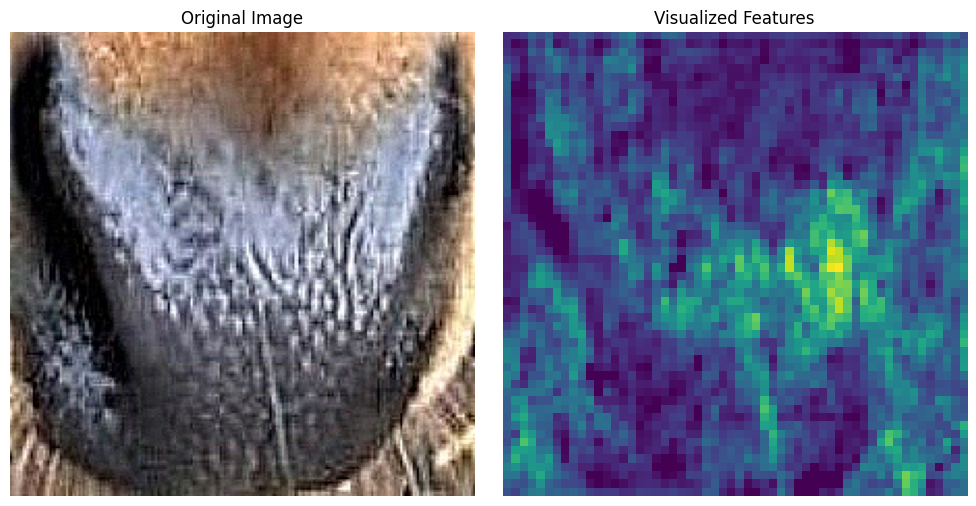

In [8]:
visualizeFeatures(img_path, feature_map, features)

**Visualizing the Maximum features in the feature map**

In [9]:
folder_path = '/content/drive/MyDrive/Colab Notebooks/VGG16/dataset/cows/cow2/'

In [10]:
def findMaximumFeature(img_path, model):
  # Choosing a layer
  layer_name = 'block3_conv1'
  layer = model.get_layer(layer_name)
  model = tf.keras.Model(inputs=model.inputs, outputs=layer.output)

  # preprocess an example cow nose image
  img = keras_image.load_img(img_path, target_size=(224, 224))
  x = keras_image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  # Get the features from the chosen layer
  features = model.predict(x)
  features = features[0]

  # Compute mean along spatial dimensions
  mean_values = np.mean(features, axis=(0, 1))

  # Get the index of the feature map with the highest statistical score
  max_mean = np.argmax(mean_values)

  return max_mean, features

def display_feature_maps(folder_path, model):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    # Set up the grid for subplots
    rows = 3
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(9, 9))

    # Ensure not to exceed the number of available images
    num_images = min(len(image_files), rows * cols)

    for i in range(num_images):
        img_file = image_files[i]
        img_path = os.path.join(folder_path, img_file)

        # Get feature maps
        feature_map, features = findMaximumFeature(img_path, model)

        # Display the feature map
        axes[i // cols, i % cols].imshow(features[..., feature_map], cmap='viridis')
        axes[i // cols, i % cols].set_title(f'{img_file}')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)  # Adjust the vertical spacing
    plt.show()

def display_feature_maps_with_original(folder_path, model):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    # Set up the grid for subplots
    rows = len(image_files)
    cols = 2  # Two columns: one for the original image and one for the feature map
    fig, axes = plt.subplots(rows, cols, figsize=(9, 3 * rows))

    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder_path, img_file)

        # Get feature maps
        feature_map, features = findMaximumFeature(img_path, model)

        # Display the original image
        original_img = keras_image.load_img(img_path, target_size=(224, 224))
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f'Original: {img_file}')
        axes[i, 0].axis('off')

        # Display the feature map
        axes[i, 1].imshow(features[..., feature_map], cmap='viridis')
        axes[i, 1].set_title(f'Feature Map: {img_file}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)  # Adjust the vertical spacing
    plt.show()

**Features Maps**

1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 191ms/step


1/1 [==============================] - 0s 186ms/step


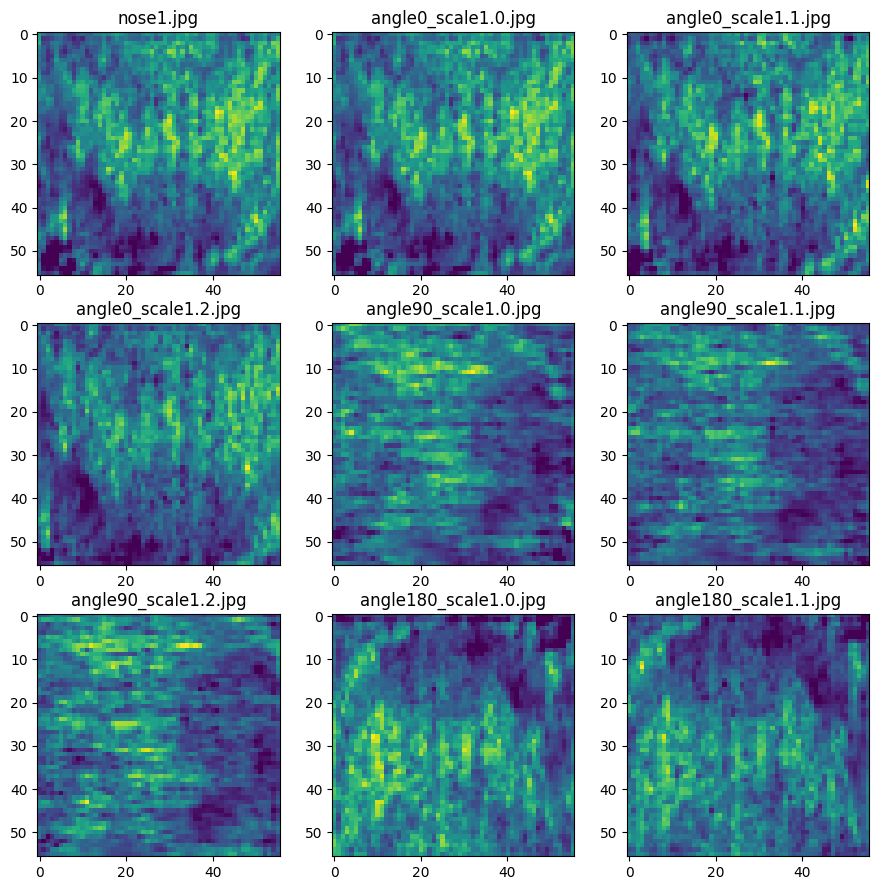

In [11]:
display_feature_maps(folder_path, model)

**Feature maps with its original image**

In [12]:
display_feature_maps_with_original(folder_path, model)


Output hidden; open in https://colab.research.google.com to view.